In [1]:
#DIR3122: Computational Fluid Dynamics - Bridget McGibbon
#Step 11: Finding a velocity and pressure field for (lid-driven) cavity flow


#i put the spaces indices in the order (x,y) instead of (y,x) as shown in the example code
#as it turns out, this isn't a switch one can make without consequences, and i don't understand how the meshgrid works
#changing the line X, Y = numpy.meshgrid(x, y) to Y, X = numpy.meshgrid(y, x) fixes the first two graphs, but the streamplot graph is still broken

In [2]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 

In [3]:
nx = 41
ny = 41
nt = 500
normtarget = 1e-4
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
#X, Y = numpy.meshgrid(x, y)
Y, X = numpy.meshgrid(y, x) #again, don't know why this fixes the plots, but whatever

rho = 1
nu = .1
dt = .001

u = numpy.zeros((nx, ny))
v = numpy.zeros((nx, ny))
p = numpy.zeros((nx, ny)) 
b = numpy.zeros((nx, ny))

In [4]:
#u=1 at y=2
#u=0 everywhere else
#v = 0 everywhere
def boundaryconditions_velocity(u,v):
        u[:,0]  = 0
        u[0,:]  = 0
        u[-1,:] = 0
        u[:,-1] = 1
        
        v[:,0]  = 0
        v[:,-1] = 0
        v[0,:]  = 0
        v[-1,:] = 0
        
        return u, v

In [5]:
def initialconditions_pressure(p):
        p[-1,:] = p[-2,:] # dp/dx = 0 at x = 2
        p[:,0] = p[:,1]   # dp/dy = 0 at y = 0
        p[0,:] = p[1,:]   # dp/dx = 0 at x = 0
        p[:,-1] = 0        # p = 0 at y = 2
        
        return p

In [6]:
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = rho * (1 / dt * 
                    ((u[2:,1:-1] - u[0:-2,1:-1]) / 
                     (2 * dx) + (v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dy)) -
                    ((u[2:,1:-1] - u[0:-2,1:-1]) / (2 * dx))**2 -
                      2 * ((u[1:-1,2:] - u[1:-1,0:-2]) / (2 * dy) *
                           (v[2:,1:-1] - v[0:-2,1:-1]) / (2 * dx))-
                          ((v[1:-1,2:] - v[1:-1,0:-2]) / (2 * dy))**2)

    return b

In [7]:
#this function produces runtime warnings because the norm is very large for the first 3 steps; don't worry about it
def pressure_poisson(p, dx, dy, b, normtarget):
    pn = numpy.empty_like(p)
    pn = p.copy()
    norm = 1
    
    while norm > normtarget:
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[2:,1:-1] + pn[0:-2,1:-1]) * dy**2 + 
                          (pn[1:-1,2:] + pn[1:-1,0:-2]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p = initialconditions_pressure(p)
        
        norm = numpy.sum(numpy.abs(p[:,:]) - numpy.abs(pn[:,:])) / numpy.sum(numpy.abs(pn[:,:]))
        
    return p

In [8]:
#V here can be either u or v (depending on the function input), and is the value being calculated
def convection_term(V, u, v, dt, dx, dy):
    
    Vn = V.copy()
    un = u.copy()
    vn = v.copy()
    
    V[1:-1, 1:-1] = -un[1:-1,1:-1]*dt/dx*(Vn[1:-1,1:-1]-Vn[0:-2,1:-1]) - vn[1:-1,1:-1]*dt/dy*(Vn[1:-1,1:-1]-Vn[1:-1,0:-2])
        
    return V

In [9]:
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b, normtarget)
        

        u[1:-1, 1:-1] = un[1:-1, 1:-1] + convection_term(u, u, v, dt, dx, dy)[1:-1,1:-1] + nu*(dt/dx**2*(un[2:,1:-1] - 2*un[1:-1, 1:-1] + un[0:-2,1:-1]) + dt/dy**2*(un[1:-1,2:] - 2 * un[1:-1, 1:-1] + un[1:-1,0:-2])) - (dt/(2 * rho * dx)*(p[2:,1:-1]-p[0:-2,1:-1]))
    
        

        v[1:-1,1:-1] =  vn[1:-1, 1:-1] + convection_term(v, u, v, dt, dx, dy)[1:-1, 1:-1] + nu*(dt/dx**2*(vn[2:,1:-1] - 2*vn[1:-1,1:-1] + vn[0:-2,1:-1]) + dt/dy**2*(vn[1:-1,2:] - 2 * vn[1:-1,1:-1] + vn[1:-1,0:-2])) - (dt/(2 * rho * dy)*(p[1:-1,2:]-p[1:-1,0:-2]))


        u, v = boundaryconditions_velocity(u,v)
        
        
    return u, v, p

In [10]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 100
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

<ipython-input-7-48bf9dd43239>:17: RuntimeWarning: invalid value encountered in double_scalars
  norm = numpy.sum(numpy.abs(p[:,:]) - numpy.abs(pn[:,:])) / numpy.sum(numpy.abs(pn[:,:]))
<ipython-input-7-48bf9dd43239>:17: RuntimeWarning: divide by zero encountered in double_scalars
  norm = numpy.sum(numpy.abs(p[:,:]) - numpy.abs(pn[:,:])) / numpy.sum(numpy.abs(pn[:,:]))


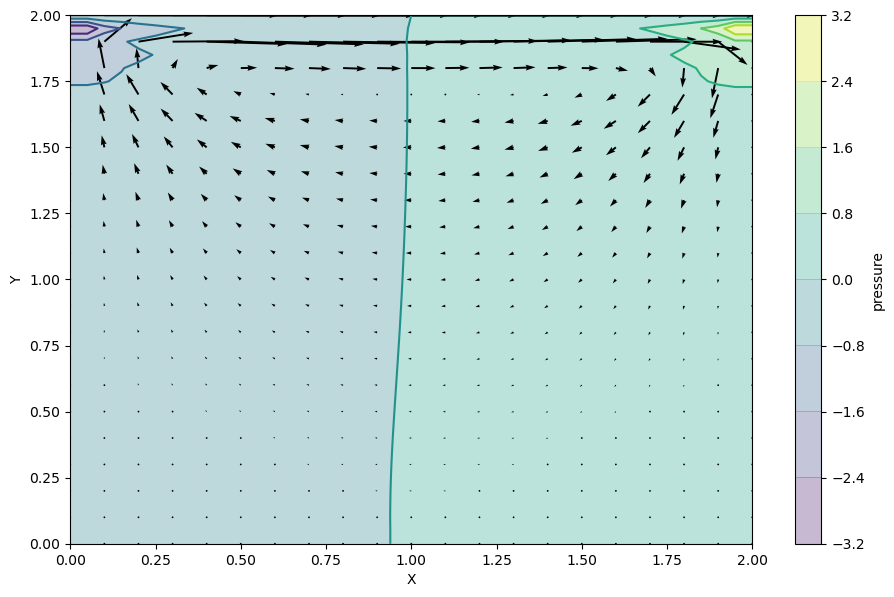

In [11]:
fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.3, cmap=cm.viridis)  
#add legend for pressure gradient
pyplot.colorbar(label="pressure")
#add outlines to pressure contours
pyplot.contour(X, Y, p, cmap=cm.viridis)
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');

In [12]:
u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

<ipython-input-7-48bf9dd43239>:17: RuntimeWarning: invalid value encountered in double_scalars
  norm = numpy.sum(numpy.abs(p[:,:]) - numpy.abs(pn[:,:])) / numpy.sum(numpy.abs(pn[:,:]))
<ipython-input-7-48bf9dd43239>:17: RuntimeWarning: divide by zero encountered in double_scalars
  norm = numpy.sum(numpy.abs(p[:,:]) - numpy.abs(pn[:,:])) / numpy.sum(numpy.abs(pn[:,:]))


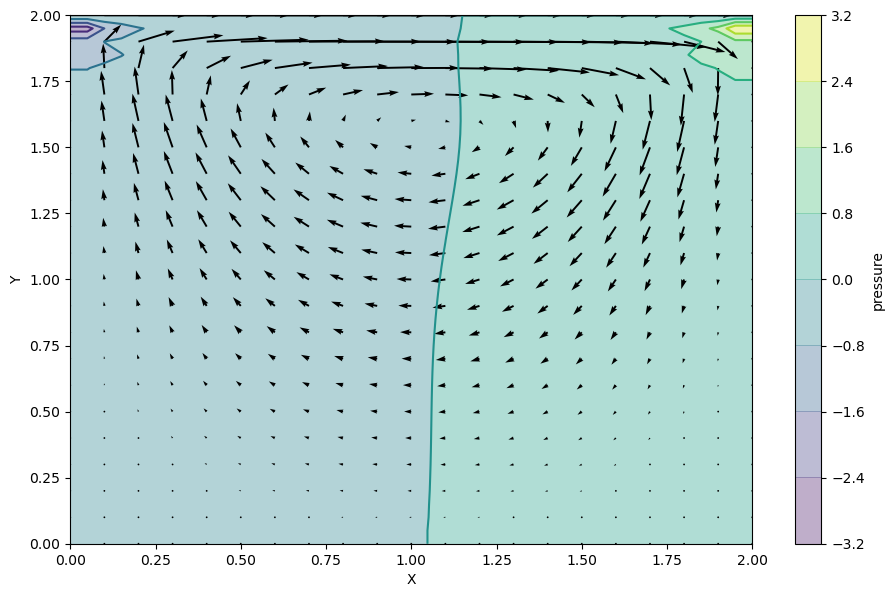

In [13]:
fig = pyplot.figure(figsize=(11, 7), dpi=100)
pyplot.contourf(X, Y, p, alpha=0.35, cmap=cm.viridis)
pyplot.colorbar(label="pressure")
pyplot.contour(X, Y, p, cmap=cm.viridis)
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
pyplot.xlabel('X')
pyplot.ylabel('Y');

In [14]:
## for some unknown reason, graphing streamplots doesn't work with the x and y indices in that order

# fig = pyplot.figure(figsize=(11, 7), dpi=100)
# pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
# pyplot.colorbar()
# pyplot.contour(X, Y, p, cmap=cm.viridis)
# #pyplot.streamplot(X, Y, u, v)
# #pyplot.streamplot(Y, X, v, u)
# #pyplot.streamplot(Y, X, u, v)
# pyplot.streamplot(X, Y, v, u)
# pyplot.xlabel('X')
# pyplot.ylabel('Y');